In [1]:
import torch
from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.ops as ops

from scipy.spatial.distance import mahalanobis

from models import build_model
from models.matcher import build_matcher

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

import seaborn as sns

import util.misc as utils

from util.misc import NestedTensor
from torch.utils.data import DataLoader

from datasets.torchvision_datasets.open_world import OWDetection
from datasets.coco import make_coco_transforms
from util import box_ops

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import tqdm
import os

from args import Args

/home/dan/anaconda3/envs/torch-cuda11/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'OWDETR': ('aeroplane', 'bicycle', 'bird', 'boat', 'bus', 'car', 'cat', 'cow', 'dog', 'horse', 'motorbike', 'sheep', 'train', 'elephant', 'bear', 'zebra', 'giraffe', 'truck', 'person', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'chair', 'diningtable', 'pottedplant', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'bed', 'toilet', 'sofa', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'tvmonitor', 'bottle', 'unknown'), 'TOWOD': ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args()

# 모델과 postprocessor 준비
model, _, postprocessors, exemplar_selection, contextual_labeling = build_model(args, mode=args.model_type)
model.to(device)

Invalid class range: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
DINO resnet50


/home/dan/anaconda3/envs/torch-cuda11/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/dan/anaconda3/envs/torch-cuda11/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


running with exemplar_replay_selection
Initialized Contextual Labeling Module


DeformableDETR(
  (transformer): DeformableTransformer(
    (encoder): DeformableTransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (self_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.1, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout2): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout3): Dropout(p=0.1, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affin

In [ ]:
def get_datasets(args):
    print(args.dataset)

    train_set = args.train_set
    test_set = args.test_set
    dataset_train = OWDetection(args, args.data_root, image_set=args.train_set, transforms=make_coco_transforms(args.train_set), dataset = args.dataset)
    dataset_val = OWDetection(args, args.data_root, image_set=args.test_set, dataset = args.dataset, transforms=make_coco_transforms(args.test_set))

    print(args.train_set)
    print(args.test_set)
    print(dataset_train)
    print(dataset_val)

    return dataset_train, dataset_val

def preprocess_image(image_path, device):
    """
    쿼리 이미지 전처리 함수: 모델이 요구하는 입력 형식으로 변환
    """
    image = Image.open(image_path).convert('RGB')
    w, h = image.size

    transform = T.Compose([
        T.Resize(800),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img_tensor = transform(image).unsqueeze(0).to(device)  # (1, C, H, W)
    return NestedTensor(img_tensor, torch.zeros_like(img_tensor[:, 0]))  # NestedTensor 변환

# Feature Representation 추출
def extract_encoder_features(model, features, pos, masks, samples):
    """
    Backbone을 통과한 Feature Map을 Transformer Encoder 입력 형식으로 변환
    """
    srcs, masks = [], []
    for l, feat in enumerate(features):
        src, mask = feat.decompose()
        srcs.append(model.input_proj[l](src))
        masks.append(mask)

    if model.num_feature_levels > len(srcs):
        _len_srcs = len(srcs)
        for l in range(_len_srcs, model.num_feature_levels):
            if l == _len_srcs:
                src = model.input_proj[l](features[-1].tensors)
            else:
                src = model.input_proj[l](srcs[-1])
            m = samples.mask
            mask = F.interpolate(m[None].float(), size=src.shape[-2:]).to(torch.bool)[0]
            pos_l = model.backbone[1](NestedTensor(src, mask)).to(src.dtype)
            srcs.append(src)
            masks.append(mask)
            pos.append(pos_l)

    # Feature Map 크기 변환
    src_flatten, mask_flatten, lvl_pos_embed_flatten, spatial_shapes = [], [], [], []
    for lvl, (src, mask) in enumerate(zip(srcs, masks)):
        bs, c, h, w = src.shape
        spatial_shapes.append((h, w))
        src = src.flatten(2).transpose(1, 2)
        mask = mask.flatten(1)
        lvl_pos_embed = model.transformer.level_embed[lvl].unsqueeze(0).repeat(1, src.shape[1], 1)
        lvl_pos_embed_flatten.append(lvl_pos_embed)
        src_flatten.append(src)
        mask_flatten.append(mask)

    src_flatten = torch.cat(src_flatten, 1)
    mask_flatten = torch.cat(mask_flatten, 1)
    lvl_pos_embed_flatten = torch.cat(lvl_pos_embed_flatten, 1)
    spatial_shapes = torch.as_tensor(spatial_shapes, dtype=torch.long, device=src_flatten.device)
    level_start_index = torch.cat((spatial_shapes.new_zeros((1, )), (spatial_shapes[:,0]*spatial_shapes[:,1]).cumsum(0)[:-1]))
    valid_ratios = torch.stack([model.transformer.get_valid_ratio(m) for m in masks], 1)

    # encoder
    memory = model.transformer.encoder(src_flatten, spatial_shapes, level_start_index, valid_ratios, lvl_pos_embed_flatten, mask_flatten)

    return memory, spatial_shapes, level_start_index, valid_ratios, mask_flatten

# Query Embedding 추출
def extract_decoder_embedding(model, memory, spatial_shapes, level_start_index, valid_ratios, mask_flatten):
    """
    Backbone을 통과한 Feature Map을 Transformer Encoder 입력 형식으로 변환
    """
    print(model.query_embed.weight)
    query_embed = model.query_embed.weight
    # prepare input for decoder
    bs, _, c = memory.shape
    if model.two_stage:
        output_memory, output_proposals = model.gen_encoder_output_proposals(memory, mask_flatten, spatial_shapes)

        # hack implementation for two-stage Deformable DETR
        enc_outputs_class = model.decoder.class_embed[model.decoder.num_layers](output_memory)
        enc_outputs_coord_unact = model.decoder.bbox_embed[model.decoder.num_layers](output_memory) + output_proposals

        topk = model.two_stage_num_proposals
        topk_proposals = torch.topk(enc_outputs_class[..., 0], topk, dim=1)[1] ##TODO?? Why only based on first dimension??
        topk_coords_unact = torch.gather(enc_outputs_coord_unact, 1, topk_proposals.unsqueeze(-1).repeat(1, 1, 4))
        topk_coords_unact = topk_coords_unact.detach()
        reference_points = topk_coords_unact.sigmoid()
        init_reference_out = reference_points
        pos_trans_out = model.pos_trans_norm(model.pos_trans(model.get_proposal_pos_embed(topk_coords_unact)))
        query_embed, tgt = torch.split(pos_trans_out, c, dim=2)
    else:
        query_embed, tgt = torch.split(query_embed, c, dim=1)
        query_embed = query_embed.unsqueeze(0).expand(bs, -1, -1)
        tgt = tgt.unsqueeze(0).expand(bs, -1, -1)
        reference_points = model.transformer.reference_points(query_embed).sigmoid()
        init_reference_out = reference_points

    # decoder
    hs, inter_references = model.transformer.decoder(tgt, reference_points, memory, spatial_shapes, level_start_index, valid_ratios, query_embed, mask_flatten)

    inter_references_out = inter_references

    if model.two_stage:
        return hs, init_reference_out, inter_references_out, enc_outputs_class, enc_outputs_coord_unact

    #return hs, init_reference_out, inter_references_out, None, None
    return hs[-1].cpu().detach().numpy()

def apply_nms(boxes, scores, labels, iou_threshold=0.5):
    """
    NMS 적용 함수
    
    Args:
        boxes: 바운딩 박스 좌표 [N, 4]
        scores: 각 박스의 confidence score [N]
        labels: 각 박스의 클래스 레이블 [N]
        iou_threshold: NMS에서 사용할 IoU threshold
    """
    # 클래스별로 NMS 적용
    unique_labels = torch.unique(labels)
    keep_boxes = []
    keep_scores = []
    keep_labels = []
    
    for label in unique_labels:
        # 현재 클래스의 박스들만 선택
        class_mask = labels == label
        class_boxes = boxes[class_mask]
        class_scores = scores[class_mask]
        
        # NMS 적용
        keep_idx = ops.nms(class_boxes, class_scores, iou_threshold)
        
        # 결과 저장
        keep_boxes.append(boxes[class_mask][keep_idx])
        keep_scores.append(scores[class_mask][keep_idx])
        keep_labels.append(labels[class_mask][keep_idx])
    
    # 모든 클래스의 결과 합치기
    if keep_boxes:
        keep_boxes = torch.cat(keep_boxes)
        keep_scores = torch.cat(keep_scores)
        keep_labels = torch.cat(keep_labels)
        return keep_boxes, keep_scores, keep_labels
    else:
        return boxes, scores, labels

def visualize_detection(image, outputs, class_names, known_score_threshold=0.3, unknown_score_threshold=0.6, unknown_label_id=80, iou_threshold=0.5):
    """
    Detection 결과 시각화 함수 (NMS 포함)
    """
    plt.figure(figsize=(12, 12))
    ax = plt.gca()
    
    # 이미지 표시
    ax.imshow(image)
    
    # 색상 맵 설정
    colors = plt.cm.rainbow(np.linspace(0, 1, unknown_label_id))
    
    # 첫 번째 이미지의 결과 가져오기
    result = outputs[0]
    
    # 각 detection에 대해
    scores = result['scores'].cpu()
    labels = result['labels'].cpu()
    boxes = result['boxes'].cpu()
    
    # score threshold 적용
    known_keep = (labels < unknown_label_id) & (scores > known_score_threshold)
    unknown_keep = (labels == unknown_label_id) & (scores > unknown_score_threshold)
    keep = known_keep | unknown_keep
    scores = scores[keep]
    labels = labels[keep]
    boxes = boxes[keep]
    
    # NMS 적용
    boxes, scores, labels = apply_nms(boxes, scores, labels, iou_threshold)
    
    for score, label, box in zip(scores, labels, boxes):
        cls_id = label.item()
        
        # 박스 좌표
        xmin = float(box[0])
        ymin = float(box[1])
        xmax = float(box[2])
        ymax = float(box[3])
        
        # 박스 그리기
        rect = patches.Rectangle(
            (xmin, ymin), 
            xmax - xmin, 
            ymax - ymin, 
            linewidth=2, 
            edgecolor=colors[cls_id] if cls_id < unknown_label_id else 'red',
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # 클래스 레이블과 confidence score 표시
        class_name = class_names[cls_id]
        ax.text(
            xmin, ymin - 5,
            f'{class_name} {score:.2f}',
            color=colors[cls_id] if cls_id < unknown_label_id else 'red',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
            fontsize=8
        )
    
    plt.axis('off')
    plt.show()


def run_inference(model, postprocessors, image_path, device='cuda'):
    """
    이미지에 대한 전체 추론 과정을 수행
    """
    # 이미지 로드
    image = Image.open(image_path).convert('RGB')
    w, h = image.size
    
    # 이미지 전처리
    transform = T.Compose([
        T.Resize([800]),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)
    print(f"Image shape: {img_tensor.shape}")

    # 원본 이미지 크기
    target_sizes = torch.tensor([[h, w]], device=device)
    
    # 모델 추론
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        results = postprocessors['bbox'](outputs, target_sizes)
    
    return image, results

In [4]:
class_names = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'truck', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'bed', 'toilet', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'unknown']

In [5]:
# 체크포인트 로드 (옵션) / Load checkpoint (optional)
checkpoint = torch.load("./test_model/my1/t1.pth", map_location=device)
model.load_state_dict(checkpoint['model'], strict=False)
model.eval()

DeformableDETR(
  (transformer): DeformableTransformer(
    (encoder): DeformableTransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (self_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.1, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout2): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout3): Dropout(p=0.1, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affin

In [6]:
dataset_train, dataset_val = get_datasets(args)

sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(sampler_train, args.batch_size, drop_last=True)
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                pin_memory=True)
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                                drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                pin_memory=True)

TOWOD
owod_t1_train
owod_all_task_test
Dataset OWDetection
    Number of datapoints: 16551
    Root location: ./data/OWOD
    [['train'], Compose(
    Compose(
)
)]
Dataset OWDetection
    Number of datapoints: 10246
    Root location: ./data/OWOD
    [['test'], Compose(
    Compose(
)
)]


In [7]:
encoder_feature_list, decoder_feature_list, known_labels = [], [], []
data_index = 21
with torch.no_grad():
    for batch_idx, (images, targets) in enumerate(tqdm.tqdm(data_loader_val)):
        
        if batch_idx != data_index:
            continue
        image = images.to(device)
        labels = targets[0]["labels"].to(device)
        features, pos = model.backbone(image)
        outputs = model(image)

        # Encoder 입력 준비
        masks = [torch.zeros_like(f.tensors[:, 0], dtype=torch.bool) for f in features]
        encoder_feature = extract_encoder_features(model, features, pos, masks, image)
        decoder_feature = extract_decoder_embedding(model, *encoder_feature)
        encoder_feature = encoder_feature[0].cpu().numpy()
        labels = labels.cpu().numpy()
        if batch_idx == data_index:
            break
        # print(encoder_feature.shape)
        # # 즉시 저장 (Append 방식)
        # append_to_file(encoder_save_path, encoder_feature)
        # append_to_file(decoder_save_path, decoder_feature)
        # append_to_file(labels_save_path, labels)

        # 불필요한 변수 삭제하여 메모리 절약
        # del encoder_feature, decoder_feature, labels

  0%|          | 1/10246 [00:00<18:32,  9.21it/s]/home/dan/anaconda3/envs/torch-cuda11/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0%|          | 21/10246 [00:00<06:00, 28.38it/s]

Parameter containing:
tensor([[ 0.4604, -0.6332,  0.2872,  ...,  0.4778, -0.1633, -0.1305],
        [ 1.0638, -2.1304,  0.2979,  ...,  0.3401, -0.5841,  0.4121],
        [ 0.1428, -0.3612, -2.1833,  ...,  0.6621, -1.4359, -1.8046],
        ...,
        [-0.9399,  0.8478,  0.8199,  ..., -0.9137, -1.0952,  0.3839],
        [ 0.3838,  0.4183,  0.5806,  ..., -1.0875,  0.3758,  0.2476],
        [-0.6110, -0.7024,  1.5823,  ..., -0.6571,  1.0689,  0.5918]],
       device='cuda:0', requires_grad=True)


In [8]:
matcher = build_matcher(args)

In [9]:
# 매칭 수행
outputs_without_aux = {k: v.to(device) for k, v in outputs.items() if k != 'aux_outputs' and k != 'enc_outputs' and k !='pred_obj'}
indices = matcher(outputs_without_aux, [{k: v.to(device) for k, v in t.items()} for t in targets])

In [10]:
outputs = {k: v.to(device).detach() if isinstance(v, torch.Tensor) else v for k, v in outputs.items()}
targets = [{k: v.to(device).detach() if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

results = contextual_labeling(outputs, targets)

matched_embeddings, unmatched_embeddings = [], []
matched_labels, unmatched_labels = [], []

for b, (matched_idx, _) in enumerate(indices):
    all_indices = set(range(outputs['pred_logits'].shape[1]))
    unmatched_idx = results[0]['unmatched']['indices']

    matched_emb = decoder_feature[b, matched_idx, :]
    unmatched_emb = decoder_feature[b, unmatched_idx, :]

    if matched_emb.ndim == 1:
        matched_emb = np.expand_dims(matched_emb, axis=0)
    if unmatched_emb.ndim == 1:
        unmatched_emb = np.expand_dims(unmatched_emb, axis=0)

    matched_embeddings.append(matched_emb)
    unmatched_embeddings.append(unmatched_emb)

# 데이터 통합
matched_embeddings = np.concatenate(matched_embeddings, axis=0)
unmatched_embeddings = np.concatenate(unmatched_embeddings, axis=0)

embeddings = np.vstack([matched_embeddings, unmatched_embeddings])
labels = np.concatenate([np.ones(results[0]['matched']['indices'].size), np.zeros(results[0]['unmatched']['indices'].size)])

Contextual: [(tensor([13, 28, 50]), tensor([1, 0, 2]))]


In [11]:
# method = "PCA"

# # 차원축소 적용 (t-SNE 또는 PCA)
# if method == 'tsne':
#     reducer = TSNE(n_components=2, random_state=42, perplexity=20)
# else:
#     reducer = PCA(n_components=2)

# reduced_embeddings = reducer.fit_transform(embeddings)

# # 시각화
# plt.figure(figsize=(10, 8))
# plt.scatter(reduced_embeddings[labels == 1, 0], reduced_embeddings[labels == 1, 1], 
#             c='blue', label='Matched', alpha=0.7, s=30)
# plt.scatter(reduced_embeddings[labels == 0, 0], reduced_embeddings[labels == 0, 1], 
#             c='red', label='Unmatched (Unknown)', alpha=0.7, s=30)
# plt.legend()
# plt.title(f'{method.upper()} Visualization of Matched vs Unmatched Embeddings')
# plt.xlabel(f'{method.upper()} Component 1')
# plt.ylabel(f"{method.upper()} Component 2")
# plt.grid(True)
# plt.show()

## Experiments

In [12]:
args.objectness_thr = 0.75

In [13]:
matched_boxes = results[0]['matched']['boxes']
unmatched_boxes = results[0]['unmatched']['boxes']
matched_labels = results[0]['matched']['labels']
unmatched_labels = results[0]['unmatched']['labels']

In [14]:
# matched와 unmatched 합치기
boxes = np.concatenate([matched_boxes, unmatched_boxes])  # [N, 4]
labels = np.concatenate([matched_labels, unmatched_labels])  # [N]
labels_type = np.array(['Matched'] * len(matched_labels) + ['Unmatched'] * len(unmatched_labels))

In [15]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

Image shape: torch.Size([1, 3, 1201, 800])


/home/dan/Desktop/Contextual_Labeling/models/prob_deformable_detr.py:537: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  topk_boxes = topk_indexes // out_logits.shape[2] # 각 인덱스가 속한 바운딩 박스 인덱스


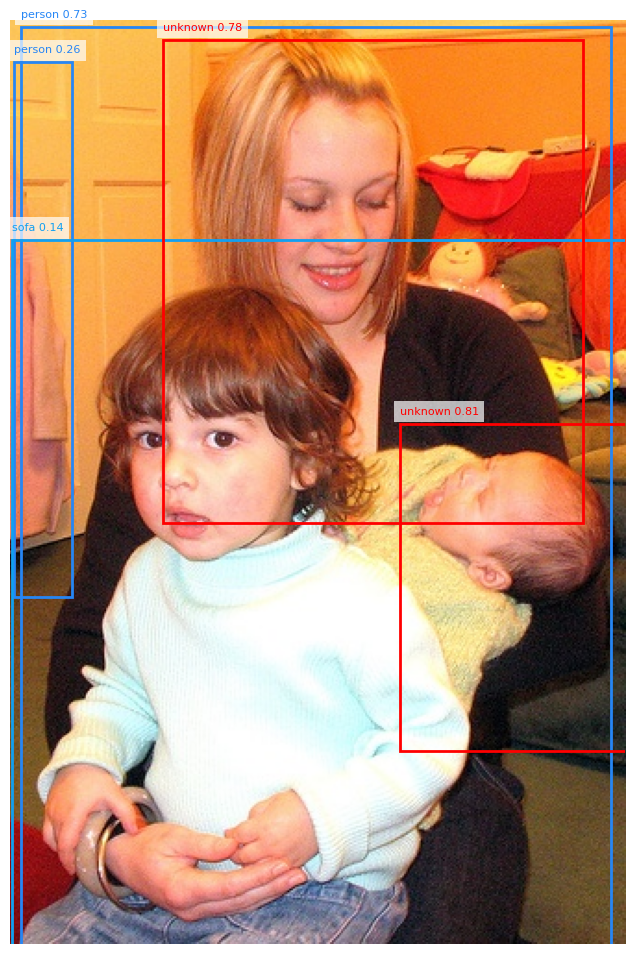

In [26]:
# 이미지 경로
image_path = f'./data/OWOD/JPEGImages/{str(targets[0]["image_id"].cpu().numpy()[0])[4:]}.jpg'#'./test_img/000002.jpg'
# 추론 및 시각화 (NMS 포함)
image, results = run_inference(model, postprocessors, image_path)
visualize_detection(image, results, class_names,
                   known_score_threshold=0.2,  # confidence threshold
                   unknown_score_threshold=args.objectness_thr, # confidence threshold for unknown class
                   iou_threshold=0.2,    # NMS IoU threshold
                   unknown_label_id=80)  # unknown class ID

In [17]:
# fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# # 왼쪽: 바운딩 박스와 인덱스, 클래스명 표시
# ax[0].imshow(image)

# for idx, (box, typ, label) in enumerate(zip(boxes, labels_type, labels)):
#     class_name = class_name = class_names[label] #f'class_{label}' if typ == 'Matched' else 'unknown'
#     xmin, ymin, xmax, ymax = box
#     color = 'blue' if typ == 'Matched' else 'red'
#     label_text = f"class_{label}" if typ == "Matched" else "unknown"
    
#     rect = patches.Rectangle(
#         (xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2,
#         edgecolor=color, facecolor='none')
#     ax[0].add_patch(rect)
#     ax[0].text(xmin, ymin-5, f"{idx}: {class_name}", fontsize=8, color='yellow', bbox=dict(facecolor='black', alpha=0.5))

# ax[0].set_title("Bounding Boxes with Indices & Class Labels")
# ax[0].axis('off')

# colors = ['blue' if t == 'Matched' else 'red' for t in labels_type]

# ax[1].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, alpha=0.8)

# # 각 점마다 인덱스 및 클래스 라벨 표기 (Bounding box와 동일한 인덱스!)
# for idx, (x, y, typ, label) in enumerate(zip(reduced_embeddings[:, 0], reduced_embeddings[:, 1], labels_type, labels)):
#     class_name = class_names[label]#f'class_{label}' if typ == 'Matched' else 'unknown'
#     ax[1].text(x, y, f"{idx} ({class_name})", fontsize=8, ha='right')

# ax[1].set_title("PCA Visualization of Matched vs Unmatched Embeddings")
# ax[1].set_xlabel("PCA Component 1")
# ax[1].set_ylabel("PCA Component 2")
# ax[1].grid(True)

# plt.tight_layout()
# plt.show()

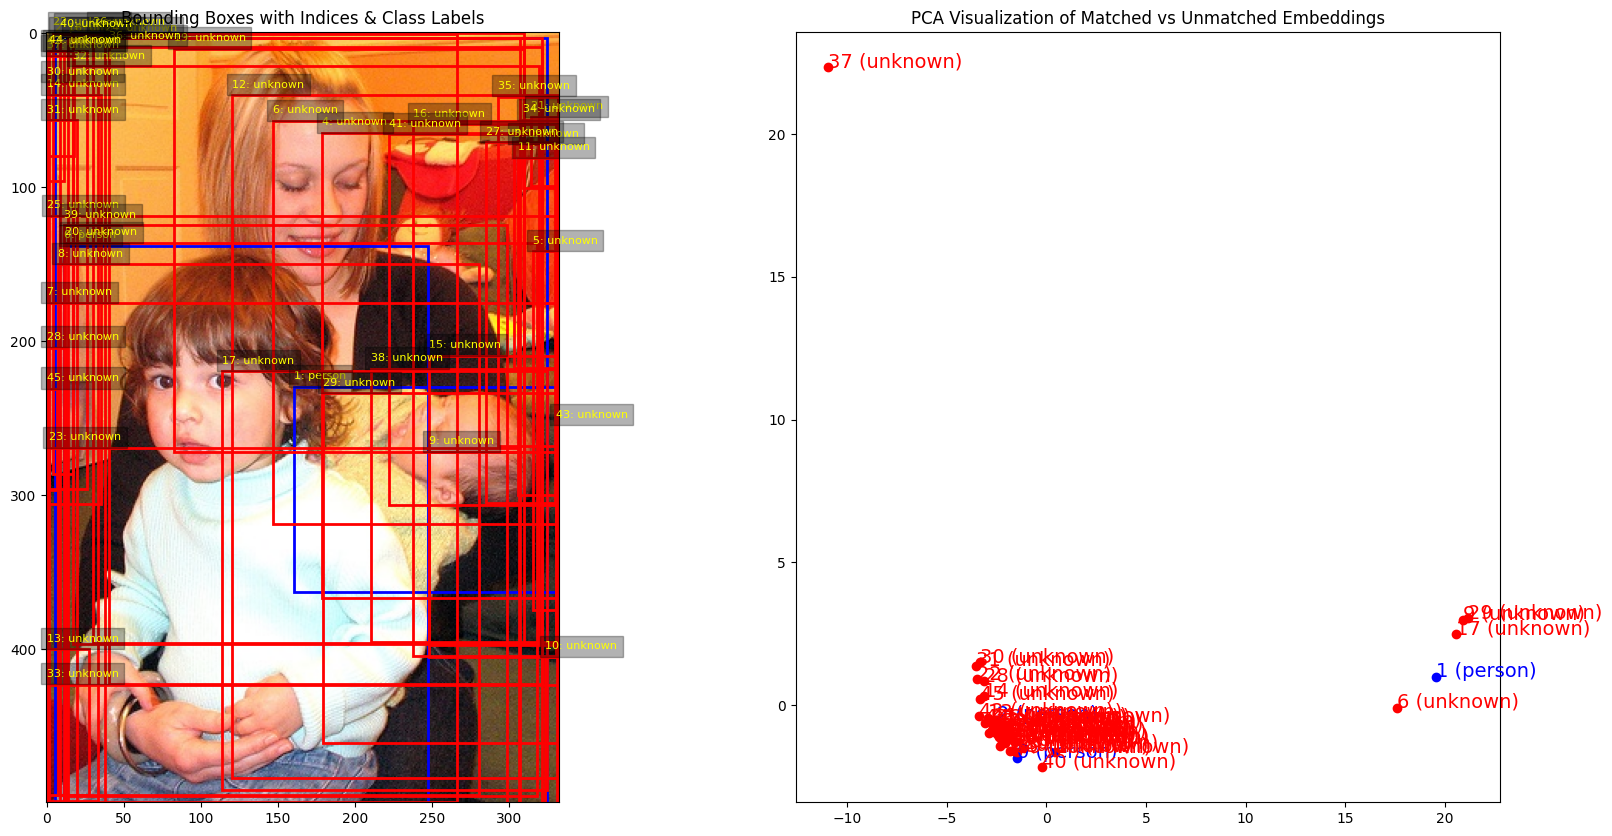

In [18]:
# def visualize_pca_with_bboxes(image, matched_boxes, unmatched_boxes, matched_labels, unmatched_labels, query_embeddings, class_names):
"""
PCA 시각화와 바운딩 박스 매칭을 동일한 인덱스로 유지하며 그리는 함수
"""
# 1. Matched + Unmatched 데이터 합치기 (순서 유지)
all_boxes = np.concatenate([matched_boxes, unmatched_boxes])
all_labels = np.concatenate([matched_labels, unmatched_labels])
all_embeddings = np.concatenate([matched_embeddings, unmatched_embeddings], axis=0)
indices = np.arange(len(all_boxes))  # 인덱스 유지

# 2. PCA 변환 (Query Embeddings)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings)

# 3. 시각화: 바운딩 박스 + PCA 그래프 함께 그리기
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
ax1, ax2 = axes

# 4. 바운딩 박스 이미지 표시
ax1.imshow(image)
ax1.set_title("Bounding Boxes with Indices & Class Labels")

for idx, (box, label) in enumerate(zip(all_boxes, all_labels)):
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2,
                                edgecolor='blue' if label < 80 else 'red', facecolor='none')
    ax1.add_patch(rect)
    
    class_label = class_names[label] if label < 80 else "unknown"
    ax1.text(xmin, ymin - 5, f"{idx}: {class_label}", fontsize=8, color='yellow',
                bbox=dict(facecolor='black', alpha=0.3))

# 5. PCA 시각화
ax2.set_title("PCA Visualization of Matched vs Unmatched Embeddings")
for idx, (x, y) in enumerate(reduced_embeddings):
    class_label = class_names[all_labels[idx]] if all_labels[idx] < 80 else "unknown"
    color = 'blue' if all_labels[idx] < 80 else 'red'
    ax2.scatter(x, y, color=color)
    ax2.text(x, y, f"{idx} ({class_label})", fontsize=14, color=color)

plt.show()

In [19]:
# 데이터 통합
# matched_embeddings[0]
unmatched_embeddings[0]

array([ 1.77097917e-01, -3.16774007e-04,  1.19423836e-01,  1.74685970e-01,
       -6.35765567e-02,  5.37071796e-03, -3.86193357e-02, -5.28745413e-01,
       -1.23491704e-01,  3.64946634e-01,  4.87728804e-01,  4.82529253e-02,
        1.18051268e-01, -3.90753523e-02, -1.29428757e-02, -1.19496003e-01,
        6.56670427e+00,  3.85212414e-02, -3.95536833e-02, -1.87967539e-01,
        2.63742536e-01, -2.26629972e-01, -9.93589386e-02,  6.43448755e-02,
        8.56172323e-01, -1.10920690e-01,  9.94387791e-02, -1.00942385e+00,
        2.26795867e-01, -1.40705287e-01,  5.79162955e-01,  7.46331587e-02,
        2.16211244e-01, -5.14950573e-01,  1.95587743e-02, -1.93711929e-02,
        7.79106855e-01, -2.92139113e-01,  1.86816230e-01,  3.39990146e-02,
        3.13671768e-01,  5.35834283e-02,  6.76636444e-03, -6.32990599e-02,
        1.23048350e-02,  2.17045709e-01,  1.51279390e-01, -1.50013417e-01,
        1.39654502e-01,  4.85673361e-02,  1.75317258e-01, -4.49813530e-02,
        6.16072603e-02, -

In [20]:
all_embeddings[1]

array([-0.88479507, -0.22722551,  1.6259154 , -0.35158265, -1.0338722 ,
        1.2132305 , -0.48474333, -1.1313899 ,  1.3363839 , -0.8329503 ,
        0.72514886, -0.67986006,  0.6714607 ,  0.8363269 , -0.24018393,
        1.2424388 ,  0.32077062, -0.39312786, -1.5666566 , -0.54726154,
       -0.8513227 , -1.0872755 , -1.2551634 , -1.0020683 ,  2.1088686 ,
       -1.1121268 , -1.2446023 ,  0.5876807 , -0.8613968 ,  1.0099791 ,
       -1.5106403 ,  0.73538977,  0.98207927,  0.19844088, -1.1142565 ,
        0.9649135 ,  0.7127717 ,  1.0856885 ,  1.025396  , -0.9344855 ,
       -1.6019229 , -0.09444794,  0.947506  , -1.3315004 ,  0.9109898 ,
        1.0771029 ,  0.7700336 ,  1.551824  ,  1.7798657 , -1.0372958 ,
        1.666458  , -0.8384666 ,  1.5508293 ,  1.1959966 , -2.3998759 ,
       -0.8879665 ,  1.4552394 ,  0.76685715,  1.2286984 , -0.4419129 ,
       -1.0809772 , -1.1873361 , -1.1663342 , -2.331353  ,  1.3642173 ,
       -1.7432454 , -1.0570668 , -1.5571487 , -2.1179829 ,  0.80

In [21]:
np.expand_dims(all_embeddings[0], 0).shape

(1, 256)

In [22]:
reduced_embeddings

array([[ -1.4787871 ,  -1.8687088 ],
       [ 19.581673  ,   0.97118   ],
       [ -2.489521  ,  -0.529571  ],
       [ -2.7142184 ,  -0.8884471 ],
       [ -2.049879  ,  -1.2399012 ],
       [ -2.0009966 ,  -1.2477483 ],
       [ 17.62146   ,  -0.09416351],
       [ -2.5017326 ,  -0.7905521 ],
       [ -1.8034121 ,  -1.5948749 ],
       [ 20.907793  ,   2.9846241 ],
       [  0.42982906,  -1.6609021 ],
       [ -2.6797123 ,  -0.5671889 ],
       [ -1.8579484 ,  -0.89676607],
       [ -2.938624  ,  -0.44907036],
       [ -3.1104693 ,   0.3047656 ],
       [ -1.7094574 ,  -1.090286  ],
       [ -2.2172549 ,  -1.1297667 ],
       [ 20.575882  ,   2.4791923 ],
       [ -2.050026  ,  -1.3432302 ],
       [ -2.4234574 ,  -1.0383637 ],
       [ -1.1139686 ,  -1.5162058 ],
       [ -2.7123344 ,  -0.6396181 ],
       [ -3.499998  ,   0.9105682 ],
       [ -2.2084398 ,  -0.75499   ],
       [ -1.9503739 ,  -0.6993018 ],
       [ -2.5311272 ,  -0.9747285 ],
       [ -2.5248594 ,  -0.62338316],
 

In [23]:
all_boxes

array([[1.11911430e+01, 1.38349182e+02, 2.47488922e+02, 5.00000000e+02],
       [1.60735809e+02, 2.29674347e+02, 3.33000000e+02, 3.63086578e+02],
       [5.25577259e+00, 3.37253523e+00, 3.24844666e+02, 5.00000000e+02],
       [3.03152222e+02, 7.21713715e+01, 3.31197540e+02, 2.17696976e+02],
       [1.78743576e+02, 6.48306046e+01, 3.32279297e+02, 3.66844269e+02],
       [3.15346954e+02, 1.41674759e+02, 3.33000000e+02, 3.74945984e+02],
       [1.46644897e+02, 5.70838318e+01, 3.32418152e+02, 3.18815247e+02],
       [0.00000000e+00, 1.75378647e+02, 3.31417694e+02, 5.00000000e+02],
       [7.21537018e+00, 1.50135529e+02, 2.80549164e+02, 4.95035522e+02],
       [2.48084152e+02, 2.72045837e+02, 3.31411987e+02, 4.05094910e+02],
       [3.23785858e+02, 4.05126556e+02, 3.33000000e+02, 5.00000000e+02],
       [3.05776459e+02, 8.10586090e+01, 3.33000000e+02, 2.99798737e+02],
       [1.20416374e+02, 4.05512733e+01, 3.33000000e+02, 4.83898254e+02],
       [0.00000000e+00, 4.00103302e+02, 2.72809811e

In [24]:
all_labels

array([14, 14, 14, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
       80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
       80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80])

In [25]:
# visualize_pca_with_bboxes(image, matched_boxes, unmatched_boxes, matched_labels, unmatched_labels, embeddings, class_names)